# Optimizing LDA Topic Modeling for Interpretability

Factors that can be altered:
- Document length distribution.
- bigram and trigram filters (i.e. filter by nouns, verbs, etc.)
    - Filterting the number of bigrams and trigram occurrences
- LDA Model
    - Passes: The number of times model iterates through the whole corpus
    - Iterations: The number of iterations the model trains on each pass
    - Chunk size: Number of rows that are taken to train the model each
    - [Additional parameters](https://radimrehurek.com/gensim/models/ldamodel.html)
- Dimensionality reduction in pyLDAvis
    - PCA or t-sne

- Other models for consideration:
    - Non-negative matrix factorization (NMF): Less computationally expensive, but assumes fixed probability vectors of multinomials across documents, while LDA allows this to vary. If we believe the topic probabilities should remain fixed for each document, or in small data setting where additional variability from priors is too much, NMF might be better.
    - [Latent semantic indexing](https://www.cs.cmu.edu/~epxing/Class/10708-15/slides/LDA_SC.pdf): a variant of PCA/SVD. Again, much faster, but generally less accurate. Similar to NMF, but different loss constraint.
    - [Hierarchical Dirchlet Process](https://en.wikipedia.org/wiki/Hierarchical_Dirichlet_process): Uses posterior inference to determine the number of topics for you

Current actions for improvement:
- Automate
    - parameter optimization selection.
    - Sample size selection
- Incorporate NGrams coding.

Objective:
- Connect Git
- Initialize Git
- Push Updates
- Apply Topic Model
- Automate Features
- Report Current Progress
- Report next steps and receive feedback.
    - Optimize notebook
    - Automate features for improved modeling
- Consider inclusion of brief break down of algorithms at the end.

In [41]:
# Load Libraries
import spacy
import nltk
nltk.download('averaged_perceptron_tagger')
import re
import string
import pandas as pd
import numpy as np
from stopwordslist import *
from cleantext import *
import gensim
from gensim import corpora
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import json
%matplotlib inline

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\donal\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


In [7]:
# Load Data
data = []
for line in open('data/reviews/meta_Prime_Pantry.json', 'r'):
    data.append(json.loads(line))

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [8]:
df = pd.DataFrame(data)

df.head()

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,category,tech1,description,fit,title,also_buy,image,tech2,brand,feature,rank,also_view,details,main_cat,similar_item,date,price,asin
0,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",[https://images-na.ssl-images-amazon.com/image...,,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO
1,[],,[Sink your sweet tooth into MILK DUDS Candya d...,,"HERSHEY'S Milk Duds Candy, 5 Ounce(Halloween C...","[B019KE37WO, B007NQSWEU]",[https://images-na.ssl-images-amazon.com/image...,,Milk Duds,[],[],[],"{'ASIN: ': 'B00005BPJO', 'Item model number:':...","<img src=""https://m.media-amazon.com/images/G/...",,,$5.00,B00005BPJO
2,[],,[A perfect Lentil soup starts with Goya Lentil...,,"Goya Dry Lentils, 16 oz","[B003SI144W, B000VDRKEK]",[https://images-na.ssl-images-amazon.com/image...,,Goya,[],[],"[B074MFVZG7, B079PTH69L, B000VDRKEK, B074M9T81...",{'ASIN: ': 'B0000DIF38'},"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIF38
3,[],,[Saran Premium Wrap is an extra tough yet easy...,,"Saran Premium Plastic Wrap, 100 Sq Ft","[B01MY5FHT6, B000PYF8VM, B000SRMDFA, B07CX6LN8...",[https://images-na.ssl-images-amazon.com/image...,,Saran,[],[],"[B077QLSLRQ, B00JPKW1RQ, B000FE2IK6, B00XUJHJ9...",{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIWNI
4,[],,[200 sq ft (285 ft x 11-3/4 in x 18.6 m2). Eas...,,"Saran Cling Plus Plastic Wrap, 200 Sq Ft",[],[https://images-na.ssl-images-amazon.com/image...,,Saran,[],[],[B0014CZ0TE],{'Domestic Shipping: ': 'This item can only be...,"<img src=""https://images-na.ssl-images-amazon....",,,,B0000DIWNZ


In [59]:
# Extract only review text and sample 1000
reviews = pd.DataFrame(df.description).sample(5000)
reviews = reviews.applymap(lambda x: x if not isinstance(x, list) else x[0] if len(x) else '')

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [60]:
# Clean reviews
clean_reviews = clean_all(reviews, 'description')

clean_reviews.head()

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,description
623,b gerber infant whole wheat cerealgerber singl...
4123,b wellness simple natural limited ingredient d...
3990,b orange pekoe contain no orange do n t feel b...
2222,b jasmine tea be the oldest know scented tea a...
10331,b about proper topper grain free turkey dog fo...


# Form Bigrams and Trigrams

In [88]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment.split()
                                                                   for comment in clean_reviews.description])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [89]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment.split()
                                                                    for comment in clean_reviews.description])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [90]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [91]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [92]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_word_list or bigram[1] in stop_word_list:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if 'PRON' in bigram:
        return False
    return True

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [93]:
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_word_list or trigram[-1] in stop_word_list or trigram[1] in stop_word_list:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if 'PRON' in trigram:
        return False
    return True

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [94]:
# PMI threshold can be set to any value which makes sense - eyeball through and select threshold where n-grams stop
# making sense. Choose top 500 ngrams, in this case, ranked by PMI that have noun like structures.
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [95]:
# Example of bigrams
bigrams[:10]


c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['united state',
 'project verify',
 'drug administration',
 'head shoulder',
 'individually wrap',
 'gmo project',
 'fructose corn',
 'tran fat',
 'fatty acid',
 'div class']

In [97]:
# Example of trigrams
trigrams[:10]

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['gmo project verify',
 'fructose corn syrup',
 'non gmo project',
 'high fructose corn',
 'wellness complete health',
 'dog food wellness',
 'food grain free',
 'dry dog food']

In [96]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [98]:
reviews_w_ngrams = clean_reviews.copy()

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [99]:
reviews_w_ngrams.description = reviews_w_ngrams.description.map(lambda x: replace_ngram(x))

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [100]:
# Tokenize comments + remove stop words + remove words with less than 2 characters
reviews_w_ngrams = reviews_w_ngrams.description.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_word_list\
                                                              and word not in english_names\
                                                              and len(word) > 2])

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [101]:
reviews_w_ngrams.head()

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


623      [gerber, infant, wheat, cerealgerber, single, ...
4123     [wellness, simple, natural, limited_ingredient...
3990     [orange, pekoe, contain, orange, feel, bad, co...
2222     [tea, oldest, know, scented, tea, numis, begin...
10331    [proper, topper, grain_free, turkey, dog_food,...
Name: description, dtype: object

## Filter for only nouns

Filtering for nouns cleans the text for words that are more interpretable in the topic model.

In [102]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [103]:
final_reviews = reviews_w_ngrams.map(noun_only)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# LDA Model

In [104]:
dictionary = corpora.Dictionary(final_reviews)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [105]:
doc_term_matrix = [dictionary.doc2bow(doc) for doc in final_reviews]

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Optimize for k topics

To improve human interpretability, let's focus on the enchancement of the Cv measures as indicated
[here](https://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf). This measure assess the interpretability of
topics given the set of words in the generated topics.

If the same words start appearing across multiple topics, the number of topics is too high.

In [116]:
# For 5-25 topics.
coherence = []
for k in range(5,26):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, id2word = dictionary, passes=50,\
                   iterations=200, chunksize = 1000, eval_every = None)

    cm = gensim.models.coherencemodel.CoherenceModel(model=ldamodel, texts=final_reviews,\
                                                     dictionary=dictionary, coherence='c_v')
    coherence.append((k,cm.get_coherence()))

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Round: 5
Round: 6
Round: 7
Round: 8
Round: 9
Round: 10
Round: 11
Round: 12
Round: 13
Round: 14
Round: 15
Round: 16
Round: 17
Round: 18
Round: 19
Round: 20
Round: 21
Round: 22
Round: 23
Round: 24
Round: 25


In [117]:
x_val = [x[0] for x in coherence]
y_val = [x[1] for x in coherence]

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


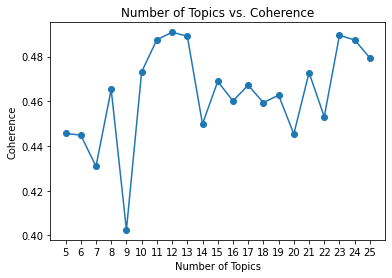

In [118]:
plt.plot(x_val,y_val)
plt.scatter(x_val,y_val)
plt.title('Number of Topics vs. Coherence')
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.xticks(x_val)
plt.show()

In [119]:
Lda = gensim.models.ldamodel.LdaModel
ldamodel = Lda(doc_term_matrix, num_topics=8, id2word = dictionary, passes=50,\
               iterations=200,  chunksize = 1000, eval_every = None, random_state=0)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [121]:
Lda2 = gensim.models.ldamodel.LdaModel
ldamodel2 = Lda2(doc_term_matrix, num_topics=13, id2word = dictionary, passes=50,\
               iterations=200,  chunksize = 1000, eval_every = None, random_state=0)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [123]:
# To show initial topics
ldamodel.show_topics(8, num_words=10, formatted=False)

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('use', 0.021591105),
   ('power', 0.01560613),
   ('design', 0.011192827),
   ('brand', 0.009887975),
   ('pain', 0.009755088),
   ('lead', 0.008870496),
   ('size', 0.007705192),
   ('bag', 0.0075981077),
   ('surface', 0.007519665),
   ('stain', 0.0072544008)]),
 (1,
  [('food', 0.02279949),
   ('health', 0.019816868),
   ('flavor', 0.016265586),
   ('product', 0.015251396),
   ('dog', 0.01524212),
   ('ingredient', 0.0128917685),
   ('dog_food', 0.012661798),
   ('taste', 0.010352699),
   ('soup', 0.009304776),
   ('support', 0.0091508)]),
 (2,
  [('cat', 0.019468462),
   ('cat_food', 0.018912861),
   ('use', 0.013227256),
   ('product', 0.011285653),
   ('image', 0.010911763),
   ('relief', 0.01000165),
   ('allergy', 0.007899641),
   ('symptom', 0.0074031926),
   ('chili', 0.007314164),
   ('food', 0.0071484786)]),
 (3,
  [('skin', 0.038932197),
   ('coffee', 0.026448125),
   ('help', 0.015925115),
   ('oil', 0.015853409),
   ('use', 0.014615338),
   ('baby', 0.0133189205

In [125]:
# To show initial topics
ldamodel2.show_topics(13, num_words=10, formatted=False)


c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  [('pain', 0.019907385),
   ('image', 0.01979555),
   ('power', 0.019052794),
   ('use', 0.017399417),
   ('design', 0.015237018),
   ('size', 0.01477752),
   ('paper', 0.013575948),
   ('wipe', 0.012814523),
   ('aid', 0.011235892),
   ('pad', 0.010784613)]),
 (1,
  [('health', 0.0391393),
   ('food', 0.028542968),
   ('dog', 0.026102692),
   ('dog_food', 0.024269078),
   ('product', 0.020222005),
   ('support', 0.01725465),
   ('company', 0.011267313),
   ('calcium', 0.0105937),
   ('bone', 0.009787439),
   ('medicine', 0.009407587)]),
 (2,
  [('relief', 0.033163145),
   ('cat', 0.031622812),
   ('cat_food', 0.03072),
   ('eye', 0.02204319),
   ('drop', 0.01734776),
   ('symptom', 0.015357668),
   ('strength', 0.013035069),
   ('allergy', 0.012172688),
   ('contain', 0.0116184335),
   ('hour', 0.010811466)]),
 (3,
  [('skin', 0.05591328),
   ('help', 0.024340825),
   ('use', 0.017580623),
   ('baby', 0.016930744),
   ('formula', 0.015702756),
   ('moisture', 0.015061152),
   ('

# Relevancy

In [128]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)


c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [127]:
topic_data =  pyLDAvis.gensim.prepare(ldamodel2, doc_term_matrix, dictionary, mds = 'pcoa')
pyLDAvis.display(topic_data)


c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [132]:
# To extract words for a given lambda.
all_topics = {}
num_terms = 10 # Adjust number of words to represent each topic
_lambda = 0.08 # Adjust this accordingly based on tuning above
for i in range(1,9): #Adjust this to reflect number of topics chosen for final LDA model
    topic = topic_data.topic_info[topic_data.topic_info.Category == 'Topic'+str(i)].copy()
    topic['relevance'] = topic['loglift']*(1-_lambda)+topic['logprob']*_lambda
    all_topics['Topic '+str(i)] = topic.sort_values(by='relevance', ascending=False).Term[:num_terms].values

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [133]:
pd.DataFrame(all_topics).T

c:\users\donal\anaconda3\envs\musicaldance\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,0,1,2,3,4,5,6,7,8,9
Topic 1,snack,chocolate,bar,chip,cracker,cereal,breakfast,crunchy,crunch,sea_salt
Topic 2,dog_food,soup,supplement,farm,health,heart,bone,boiron,knorr,quaker
Topic 3,skin,coffee,lotion,moisturizer,body_wash,foot,diaper,cleanser,roast,green_superfood
Topic 4,hair,shampoo,conditioner,tea,curl,lip,dandruff,shine,iced_tea,repair
Topic 5,paper,grip,sheet,ache,detergent,view,bandage,stain,battery,clothe
Topic 6,cat,cat_food,chili,lash,image,div_class,cough,spicy,throat,mascara
Topic 7,drop,breath,chew,pencil,gum,toothpaste,pentel,discomfort,mouthwash,plaque
Topic 8,deodorant,breast,axe,bacon,label,potato_chip,sport,restaurant,kraft,loss
